Translation of Alphabets Gestures into English. Though it can work marvelously with the test data with such high accuracy, it fails miserably in real-time translation. The Kaggle kernels were used to train the model.

Model Description - Three different types of models were tried.
* Slim-Net can achieve an accuracy of 30% with real-time data.
* The basic CNN model can achieve an accuracy of 25% with real-time data.
* The transfer learning models depend on the pre-trained network. Resnet50 was able to achieve 40% accuracy while Xception reached 60%.

95%+ accuracy was achieved by all the models on the test data. But here, more importance is given to data, which can have different lighting conditions,  various skintones, and miscellaneous noises.

The datasets used are all available in Kaggle. Due to the limitations of free usage, the images were compressed to 72x72, and 2000 images per alphabet were used. Futher improvements will be done, and updated regulary.

In [9]:
%matplotlib inline

import os
import numpy
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

import cv2
import tensorflow
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, DepthwiseConv2D, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
alphabets_directory_01 = "../input/big-asl/kaggle"
alphabets_directory_02 = "../input/significant-asl-sign-language-alphabet-dataset/Training Set"
alphabets_directory_03 = "../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
# alphabets_directory_03 = "../input/american-sign-language-dataset/asl"

In [3]:
input_shape = (72, 72, 3)
classes = 26
batch = 128
epochs = 5

In [5]:
inputs = Input(shape=input_shape)
net = Conv2D(32, kernel_size=3, strides=1, padding="same")(inputs)
net = LeakyReLU()(net)
net = Conv2D(32, kernel_size=3, strides=1, padding="same")(net)
net = LeakyReLU()(net)
net = Conv2D(32, kernel_size=3, strides=2, padding="same")(net)
net = LeakyReLU()(net)

net = Conv2D(32, kernel_size=3, strides=1, padding="same")(net)
net = LeakyReLU()(net)
net = Conv2D(32, kernel_size=3, strides=1, padding="same")(net)
net = LeakyReLU()(net)
net = Conv2D(32, kernel_size=3, strides=2, padding="same")(net)
net = LeakyReLU()(net)

shortcut = net

net = DepthwiseConv2D(kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(net)
net = BatchNormalization(axis=3)(net)
net = LeakyReLU()(net)
net = Conv2D(filters=32, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(net)
net = BatchNormalization(axis=3)(net)
net = LeakyReLU()(net)

net = DepthwiseConv2D(kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(net)
net = BatchNormalization(axis=3)(net)
net = LeakyReLU()(net)
net = Conv2D(filters=32, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(net)
net = BatchNormalization(axis=3)(net)
net = LeakyReLU()(net)

net = Add()([net, shortcut])

net = GlobalAveragePooling2D()(net)
net = Dropout(0.2)(net)

net = Dense(128, activation='relu')(net)
outputs = Dense(classes, activation='softmax')(net)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 72, 72, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 72, 72, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 72, 72, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 72, 32)   9248        leaky_re_lu[0][0]                
_______________________________________________________________________________________

Here the Xception model is used, though others such as ResNet50 or VGG16 can be used as well. The layers are made trainable, since the sign language gesture patterns has to learned by the model.

In [6]:
model = Xception(weights = 'imagenet', include_top=False, input_shape=input_shape)
# for layer in model.layers:
# 	layer.trainable = False

flat0 = Flatten()(model.layers[-1].output)
class0 = Dense(1024, activation='relu')(flat0)
class1 = Dense(256, activation='relu')(class0)
class2 = Dense(62, activation='relu')(class1)
output = Dense(classes, activation='softmax')(class2)

model = Model(inputs=model.inputs, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 72, 72, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
______________________

In [7]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 72, 72, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 18, 18, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 256)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 9, 9, 256)         1

Three datasets are used in for this model. Each image is compressed into 72x72 size, and later the ascii value of the folder is used to label the data. Finally the complete array of images is normalized and the labels are one-hot encoded.

In [8]:
X = []
Y = []
image_size = 72, 72

folders_list = sorted(os.listdir(alphabets_directory_01))
# print(folders_list)
for folder in folders_list:
    alphabet_folder = os.listdir(alphabets_directory_01 + "/" + folder)[:400]
    for image in alphabet_folder:
        cv2_image = cv2.imread(alphabets_directory_01 + '/' + folder + '/' + image)
        X.append(cv2.resize(cv2_image, image_size))
    Y.extend([ord(folder) - ord('A')] * len(alphabet_folder))
    
folders_list = sorted(os.listdir(alphabets_directory_02))[:-1] 
# print(folders_list)
for folder in folders_list:
    alphabet_folder = os.listdir(alphabets_directory_02 + "/" + folder)[:800]
    for image in alphabet_folder:
        cv2_image = cv2.imread(alphabets_directory_02 + '/' + folder + '/' + image)
        X.append(cv2.resize(cv2_image, image_size))
    Y.extend([ord(folder) - ord('A')] * len(alphabet_folder))

folders_list = sorted(os.listdir(alphabets_directory_03))[:-3]
# folders_list.remove('asl')
# print(folders_list)
for folder in folders_list:
    alphabet_folder = os.listdir(alphabets_directory_03 + "/" + folder)[:800]
    for image in alphabet_folder:
        cv2_image = cv2.imread(alphabets_directory_03 + '/' + folder + '/' + image)
        X.append(cv2.resize(cv2_image, image_size))
    Y.extend([ord(folder) - ord('A')] * len(alphabet_folder))

images = numpy.array(X)
images = images.astype('float32')/255.0
labels = utils.to_categorical(Y)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1)

In [10]:
history = model.fit(x_train, y_train, batch_size=batch, epochs=epochs, validation_split=0.1, shuffle = True, verbose=1)

Epoch 1/5
322/322 [==============================] - 11s 34ms/step - loss: 1.2825 - accuracy: 0.6066 - val_loss: 1.5630 - val_accuracy: 0.6801
Epoch 2/5
322/322 [==============================] - 11s 35ms/step - loss: 0.4124 - accuracy: 0.8669 - val_loss: 0.3530 - val_accuracy: 0.8939
Epoch 3/5
322/322 [==============================] - 10s 32ms/step - loss: 0.2279 - accuracy: 0.9263 - val_loss: 0.2916 - val_accuracy: 0.9102
Epoch 4/5
322/322 [==============================] - 10s 32ms/step - loss: 0.1655 - accuracy: 0.9459 - val_loss: 0.2327 - val_accuracy: 0.9266
Epoch 5/5
322/322 [==============================] - 10s 33ms/step - loss: 0.1313 - accuracy: 0.9572 - val_loss: 0.2147 - val_accuracy: 0.9430


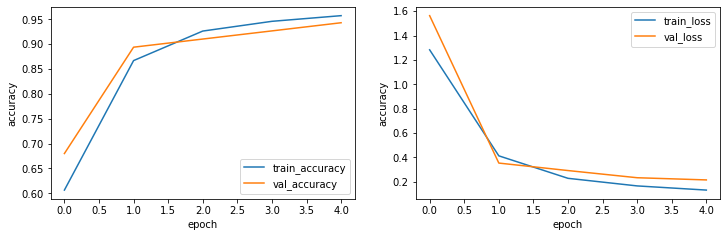

In [11]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [12]:
start = time.time()
model.evaluate(x_test, y_test)
end = time.time()
print(end - start)

159/159 [==============================] - 1s 5ms/step - loss: 0.2031 - accuracy: 0.9379
1.2681303024291992


In [13]:
predictions = numpy.argmax(model.predict(x_test), axis =1)
labels = numpy.argmax(y_test, axis=1)
tensorflow.math.confusion_matrix(labels, predictions)

<tf.Tensor: shape=(26, 26), dtype=int32, numpy=
array([[180,   0,   5,   0,   3,   0,   0,   0,   0,   0,   0,   0,   6,
          1,   1,   1,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0],
       [  1, 190,   0,   5,   6,   0,   0,   0,   0,   0,   1,   1,   0,
          0,   0,   1,   0,   1,   0,   0,   4,   0,   0,   0,   2,   0],
       [  0,   0, 194,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   1,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   1, 196,   1,   0,   0,   0,   0,   0,   0,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   0],
       [  1,   0,   0,   3, 184,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   3,   0, 194,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   1,   0,   1,   0, 166,  11,   0,   0,   0,   0,   

In [14]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")

Once the models are saved on to the local device, the below script can be used to test the accuracy of the model using custom dataset. Just change the directory to the location, where the alphabets are stored. Need to make sure, each alphabet has its own directory for the below script to run well.

In [ ]:
from tensorflow.keras.models import model_from_json
import cv2
import numpy
import tensorflow.keras as keras
import os

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z']
directory = "Dataset/Test Data"

json_file = open('model.json', 'r')
model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(model_json)
loaded_model.load_weights("model.h5")
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

X = []
Y = []
image_size = 72,72

folders_list = sorted(os.listdir(directory))
# print(folders_list)
for folder in folders_list:
    alphabet_folder = os.listdir(directory + "/" + folder)[:100]
    for image in alphabet_folder:
        cv2_image = cv2.imread(directory + '/' + folder + '/' + image)
        cv2_image = cv2.resize(cv2_image, image_size)
        X.append(cv2_image)
    Y.extend([ord(folder) - ord('A')] * len(alphabet_folder))

images = numpy.array(X)
images = images.astype('float32')/255.0
labels = keras.utils.to_categorical(Y)

loaded_model.evaluate(images, labels)